In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import json
import re

In [2]:
# Read the dataset
df = pd.read_excel('./dataset.xlsx', sheet_name='main')
val_df = pd.read_excel('./dataset.xlsx', sheet_name='val-similarity')

In [3]:
df.head()

,field,q,a1,a2,a3,a4,a5,a6,a7,a8,...,a41,a42,a43,a44,a45,a46,a47,a48,a49,a50
0,General - Tentang Perusahaan,Bisakah Anda menjelaskan apa yang membuat Anda...,Saya tertarik untuk bekerja di perusahaan ini ...,Saya terkesan dengan visi dan misi perusahaan ...,Saya tertarik dengan reputasi perusahaan ini d...,Saya melihat bahwa perusahaan ini memberikan k...,Saya tertarik untuk bekerja di perusahaan ini ...,Saya merasa bahwa perusahaan ini adalah tempat...,Saya tertarik dengan inovasi yang ditanamkan o...,Saya ingin bekerja di perusahaan ini karena sa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,General - Tentang Perusahaan,Apa yang Anda ketahui tentang perusahaan ini?,Saya telah melakukan penelitian mendalam tenta...,Saya tahu bahwa perusahaan ini telah memenangk...,Perusahaan ini memiliki kehadiran global yang ...,Saya telah melihat bahwa perusahaan ini aktif ...,Saya tahu bahwa perusahaan ini memiliki budaya...,Saya mengetahui bahwa perusahaan ini sedang be...,"Dari apa yang saya baca, perusahaan ini memili...",Saya tahu bahwa perusahaan ini memiliki sejara...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,General - Tentang Perusahaan,Kenapa anda memilih perusahaan ini daripada pe...,Saya memilih perusahaan ini karena saya sangat...,Salah satu alasan utama saya memilih perusahaa...,Saya tertarik dengan perusahaan ini karena say...,Salah satu hal yang membuat perusahaan ini men...,Saya melihat bahwa perusahaan ini memberikan p...,Saya telah melakukan riset yang mendalam tenta...,Salah satu faktor yang mempengaruhi pilihan sa...,Saya telah berbicara dengan beberapa mantan da...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,General - Latar Belakang User,Apa proyek atau pencapaian terbesar dalam kari...,Salah satu pencapaian terbesar saya adalah saa...,Proyek terbesar dalam karier saya adalah ketik...,Saya memiliki kesempatan untuk mengembangkan p...,Salah satu pencapaian terbesar saya adalah ket...,Proyek terbesar dalam karier saya adalah ketik...,Saya berhasil merancang dan mengelola proyek k...,"Ketika saya bekerja sebagai manajer pemasaran,...",Saya berkontribusi dalam proyek pengembangan p...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,General - Latar Belakang User,Bisakah Anda berbagi contoh tentang bagaimana ...,"Dalam proyek sebelumnya, saya meningkatkan efi...",Saya merasa efisiensi dalam proyek sebelumnya ...,"Di proyek sebelumnya, saya memperkenalkan otom...",Untuk meningkatkan produktivitas dalam proyek ...,Saya berhasil meningkatkan efisiensi proyek se...,"Dalam proyek terakhir saya, saya memperkenalka...",Salah satu langkah yang saya ambil untuk menin...,"Dalam proyek sebelumnya, saya menggunakan tekn...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Declare a class softmax for label
df_field_values = df['field']
questionClass = {value: index for index, value in enumerate(df_field_values.unique())}
print('total class: ' + str(len(questionClass)))
questionClass

total class: 16


{'General - Tentang Perusahaan': 0,
 'General - Latar Belakang User': 1,
 'General - Terkait Posisi': 2,
 'General - Softskill Situasional': 3,
 'Penutup': 4,
 'Kuliner dan Restoran': 5,
 'Penjualan dan Pemasaran': 6,
 'Layanan Pelanggan': 7,
 'Administrasi dan Akuntansi': 8,
 'Desain Grafis': 9,
 'IT': 10,
 'Keamanan': 11,
 'Kesehatan': 12,
 'Pendidikan': 13,
 'Hiburan': 14,
 'Perhotelan': 15}

In [5]:
# Combine every answer of each question for training and validation
dfKey, dfValue = list(df)[0], list(df)[2::]
answers, labels = [], []
for i in range(len(dfValue)):
    for j in range(len(df[dfValue[i]])):
        answer = df[dfValue[i]][j]
        if pd.isna(answer): continue
        answers.append(answer)
        labels.append(questionClass[df[dfKey][j]])

dfKey, dfValue = list(val_df)[0], list(val_df)[2:5]
val_answers, val_labels = [], []
for i in range(len(dfValue)):
    for j in range(len(val_df[dfValue[i]])):
        val_answer = val_df[dfValue[i]][j]
        if pd.isna(val_answer): continue
        val_answers.append(val_answer)
        val_labels.append(questionClass[val_df[dfKey][j]])

In [6]:
answers[:5], labels[:5]

(['Saya tertarik untuk bekerja di perusahaan ini karena saya percaya bahwa perusahaan ini menawarkan lingkungan kerja yang sangat inovatif dan dinamis, di mana saya dapat terus berkembang dan memberikan dampak nyata.',
  'Saya telah melakukan penelitian mendalam tentang perusahaan ini dan saya tahu bahwa Anda adalah pemimpin dalam industri ini, terkenal karena inovasi dan komitmen terhadap keberlanjutan.',
  'Saya memilih perusahaan ini karena saya sangat terinspirasi oleh visi dan misi perusahaan untuk menciptakan dampak positif dalam industri. Saya ingin menjadi bagian dari tim yang berdedikasi untuk mencapai tujuan tersebut.',
  'Salah satu pencapaian terbesar saya adalah saat saya memimpin tim dalam peluncuran produk baru yang sukses. Saya berkontribusi dalam merancang strategi pemasaran yang inovatif dan memastikan pelaksanaan yang lancar.',
  'Dalam proyek sebelumnya, saya meningkatkan efisiensi dengan mengimplementasikan alat manajemen tugas online yang memungkinkan tim saya unt

In [7]:
print(f'Train data: {len(answers)}')
print(f'Validation data: {len(val_answers)}')

Train data: 2790
Validation data: 408


In [8]:
# Counting every word to get the most used word / common word from the dataset
wordList = []
for item in answers:
    words = item.split()
    for word in words:
        wordList.append(re.sub(r'[^\w\d\s]', '', word.lower()))
result = dict(Counter(wordList))
commonworddata = sorted(result.items(), key=lambda x: x[1], reverse=True)
commonworddata[:3]

[('saya', 6502), ('dan', 4564), ('yang', 3844)]

In [9]:
# Saving common word data into json
word_list = [{'word': item[0], 'count': item[1]} for item in commonworddata]
with open('common_words.json', 'w') as json_file:
    json.dump(word_list, json_file, indent=4)

In [10]:
# Splitting common word and the frequencies each word into two different array
commonword, frequencies = zip(*commonworddata)

<h3>Preprocessing text</h3>
The step of our preprocessing text is:
<ol>
    <li>Remove non alphabet using regex</li>
    <li>Make every word into lower case</li>
    <li>Removing common word from the sentences until max_length parameter reached</li>
        In this case, our maximum length of inputed word is 25.<br>
        So, inputed sentences will be keep decreased until 25 words.
</ol>

In [11]:
max_length = 25

In [12]:
def preprocessing_text(sentence, max_length):
    filtered_words = re.sub(r'[^\w\d\s]', '', sentence.lower())
    words = word_tokenize(filtered_words)
    prevLen = len(words)
    for i in range(len(commonword)):
        if (len(words) <= max_length): break
        words = [word for word in words if word.lower() not in [commonword[i]]]
        if (len(words) == prevLen): break
    return ' '.join(words)

In [13]:
answers[0]

'Saya tertarik untuk bekerja di perusahaan ini karena saya percaya bahwa perusahaan ini menawarkan lingkungan kerja yang sangat inovatif dan dinamis, di mana saya dapat terus berkembang dan memberikan dampak nyata.'

In [14]:
temp = []
for answer in answers:
    temp.append(preprocessing_text(answer, max_length))
answers = temp

temp = []
for answer in val_answers:
    temp.append(preprocessing_text(answer, max_length))
val_answers = temp

In [15]:
answers[0]

'tertarik untuk bekerja di perusahaan ini karena percaya bahwa perusahaan ini menawarkan lingkungan kerja sangat inovatif dinamis di mana dapat terus berkembang memberikan dampak nyata'

In [16]:
# Counting vocabulary size to avoid overfitting or underfitting
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(answers)
vocab_size = len(vectorizer.get_feature_names_out())
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 3539


In [17]:
# Splitting training and validation data
training_sentences = answers
testing_sentences = val_answers
training_labels = labels
testing_labels = val_labels

In [18]:
# Converting the data into sequences and give a padding
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [19]:
# Saving training sentences data into json
word_dict = {item[0]: item[1] for item in tokenizer.word_index.items()}
with open('tokenizer_dict_scoring.json', 'w') as json_file:
    json.dump(word_dict, json_file, indent=4)

In [20]:
# Declare graph function
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.ylim(bottom=0)
    plt.show()

In [21]:
# declare the model
embedding_dim = 256
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(questionClass), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 256)           905984    
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                4112      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
Total params: 910,368
Trainable params: 910,368
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
88/88 - 1s - loss: 2.6769 - accuracy: 0.2785 - val_loss: 2.5081 - val_accuracy: 0.4461 - 1s/epoch - 13ms/step
Epoch 2/15
88/88 - 1s - loss: 2.1206 - accuracy: 0.5638 - val_loss: 1.7649 - val_accuracy: 0.6789 - 663ms/epoch - 8ms/step
Epoch 3/15
88/88 - 1s - loss: 1.2955 - accuracy: 0.7731 - val_loss: 1.1415 - val_accuracy: 0.7966 - 632ms/epoch - 7ms/step
Epoch 4/15
88/88 - 1s - loss: 0.7671 - accuracy: 0.8749 - val_loss: 0.8649 - val_accuracy: 0.8064 - 644ms/epoch - 7ms/step
Epoch 5/15
88/88 - 1s - loss: 0.4915 - accuracy: 0.9143 - val_loss: 0.7039 - val_accuracy: 0.8309 - 637ms/epoch - 7ms/step
Epoch 6/15
88/88 - 1s - loss: 0.3344 - accuracy: 0.9423 - val_loss: 0.6241 - val_accuracy: 0.8382 - 620ms/epoch - 7ms/step
Epoch 7/15
88/88 - 1s - loss: 0.2350 - accuracy: 0.9674 - val_loss: 0.5778 - val_accuracy: 0.8456 - 623ms/epoch - 7ms/step
Epoch 8/15
88/88 - 1s - loss: 0.1668 - accuracy: 0.9778 - val_loss: 0.5462 - val_accuracy: 0.8333 - 603ms/epoch - 7ms/step
Epoch 9/15
88/88 -

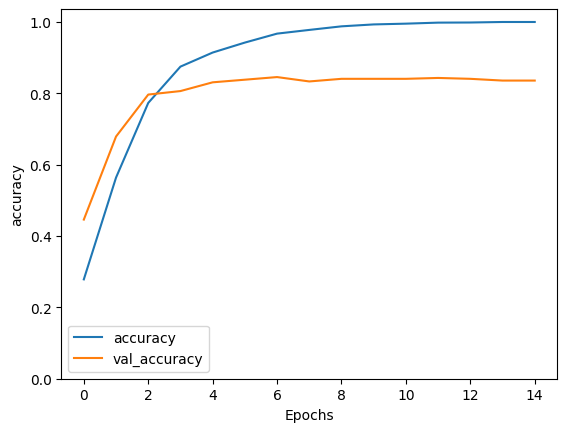

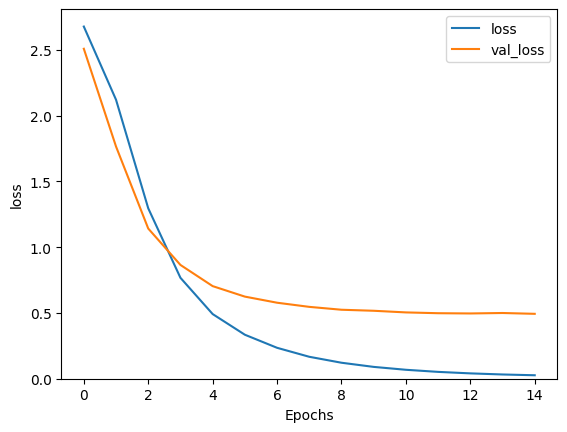

In [22]:
model.compile(loss='SparseCategoricalCrossentropy',optimizer=Adam(0.001),metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=15, validation_data=(testing_padded, testing_labels), verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

<h3>Demo</h3>

In [23]:
# Define a Cosine Similarity Algorithm
def cosine_similarity(str1, str2):
    arr1 = preprocessing_text(str1, max_length).split(' ');
    arr2 = preprocessing_text(str2, max_length).split(' ');
    common_elements = sorted(list(filter(lambda element: element in arr2, arr1)))
    unique_arr1 = list(filter(lambda element: element not in arr2, arr1))
    unique_arr2 = list(filter(lambda element: element not in arr1, arr2))
    arr1a = common_elements + unique_arr1
    arr2a = common_elements + unique_arr2
    total_same_word = len(arr1) - len(unique_arr1)
    set1 = set(arr1a)
    set2 = set(arr2a)
    count1 = 0
    count2 = 0
    for element in arr1a:
        if element not in set2:
            count1 += 1

    for element in arr2a:
        if element not in set1:
            count2 += 1
    arr1b = arr1a + [None] * count2
    arr2b = arr2a + [None] * count1
    def switch_element_by_index(arr, idx1, idx2):
        arr[idx1], arr[idx2] = arr[idx2], arr[idx1]
    for i in range(len(arr1b)):
        if i < total_same_word:
            continue
        if arr1b[i] is not None and arr2b[i] is not None:
            switch_element_by_index(arr2b, i, len(arr1b) - 1)
    D1 = []
    D2 = []
    for i in range(len(arr1b)):
        if i < total_same_word:
            D1.append(1)
            D2.append(1)
        elif arr1b[i] is None:
            D1.append(0)
            D2.append(1)
        elif arr2b[i] is None:
            D1.append(1)
            D2.append(0)
    D1D2 = 0
    D1Sum = sum(D1)
    D2Sum = sum(D2)
    for i in range(len(D1)):
        D1D2 += D1[i] * D2[i]
    Similarity = D1D2 / (D1Sum ** 0.5 * D2Sum ** 0.5)
    return Similarity

# Label decode function for predict reesult
def get_key_by_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None

# Predict function
def predict(text):
    preprocessed_text = preprocessing_text(text, max_length)
    input_sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_input = pad_sequences(input_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded_input, verbose=0)
    top_indices = np.argmax(predictions)
    result = get_key_by_value(questionClass, top_indices)
    return result

In [24]:
# Demo
def scoring(tes_q, tes_a):
    listAnswer = []
    field = ''
    for i in range(len(df['q'])):
        if df['q'][i] == tes_q:
            field = df['field'][i]
            for j in range(len(list(df)[2:])):
                answer = df[list(df)[2:][j]][i]
                if pd.isna(answer): break
                listAnswer.append(answer)

    result_field = predict(tes_a)
    if result_field == field:
        result_field = True
    else :
        result_field = False

    scoring_similarity_list = []
    for i in range(len(listAnswer)):
        scoring_similarity_list.append(cosine_similarity(tes_a, listAnswer[i]))
    result_similarity = max(scoring_similarity_list)
    total_score = result_field * 0.5 + result_similarity * 0.5
    print(f"Your answer is {'Relate' if result_field else 'Not Relate'} with a similarity of {result_similarity}")
    print('Total score:', total_score)

In [25]:
# Demo: Pertanyaan dengan field Kuliner dan Restoran dengan jawaban yang bagus
q = 'Bagaimana Anda mendefinisikan konsep kuliner yang unik?'
a = 'Bagi saya, kuliner yang unik melibatkan eksperimen dalam menciptakan rasa baru yang belum pernah dikenal sebelumnya. Proses ini melibatkan penggabungan bahan, teknik memasak inovatif, dan cara penyajian yang menarik.'
scoring(q, a)

Your answer is Relate with a similarity of 0.753778361444409
Total score: 0.8768891807222046


In [26]:
# field: Pertanyaan dengan field Kuliner dan Restoran dengan jawaban yang kurang tepat namun tetap satu bidang
q = 'Bagaimana Anda mendefinisikan konsep kuliner yang unik?'
a = 'Memiliki berbagai pilihan pemasok adalah strategi saya untuk mengurangi risiko ketika ada gangguan pasokan atau kenaikan harga. Ini membantu menjaga fleksibilitas produksi.'
scoring(q, a)

Your answer is Relate with a similarity of 0.35777087639996635
Total score: 0.6788854381999831


In [27]:
# field: Pertanyaan dengan field Kuliner dan Restoran dengan jawaban yang tidak tepat dan beda bidang
q = 'Bagaimana Anda mendefinisikan konsep kuliner yang unik?'
a = 'Untuk mencegah masalah yang sama terulang, saya akan mengadakan pertemuan "tindakan perbaikan" yang melibatkan tim terkait. saya akan mengevaluasi tindakan yang telah diambil untuk mengatasi masalah tersebut dan memastikan implementasi perbaikan yang sesuai. Untuk mencegah masalah baru, saya akan mendorong tim untuk berpikir kritis dan aktif mencari tanda-tanda potensi masalah.'
scoring(q, a)

Your answer is Not Relate with a similarity of 0.18650096164806276
Total score: 0.09325048082403138
